In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from random import randint
import matplotlib

import numpy as np
import torch

import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
import torch
# if you are on GPU (encoding ~1000 sentences/s, default)
# if you are on CPU (~40 sentences/s)
infersent = torch.load('infersent.allnli.pickle', map_location=lambda storage, loc: storage)

C:\Users\User\Anaconda3\lib\site-packages\torch\serialization.py:367: SourceChangeWarning: source code of class 'models.BLSTMEncoder' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
C:\Users\User\Anaconda3\lib\site-packages\torch\serialization.py:367: SourceChangeWarning: source code of class 'torch.nn.modules.rnn.LSTM' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


In [3]:
glove_path = 'SentEval/pretrained/glove.840B.300d.txt'
infersent.set_glove_path(glove_path)

In [34]:
infersent.build_vocab_k_words(K=300000)

300002
Vocab size : 300000


C:\Users\User\Google Drive\Universiteit\Master\Unsupervised Language Learning\ULL Practicals\3\models.py:237: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  batch = Variable(self.get_batch(sent), volatile=True)


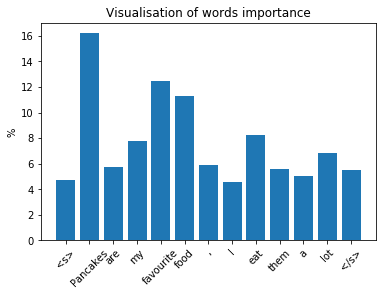

In [42]:
my_sent = 'Pancakes are my favourite food, I eat them a lot'
_, _,y = infersent.visualize(my_sent,tokenize=True,visualize=True)

In [20]:
def redistribute_start_stop(y):
    # Function to redistribute the start and stop words importance over the rest
    
    # Remove first and last element (start and stop symbol)
    del y[0]
    del y[-1]
    
    # convert to float
    y = [float(i) for i in y]
    
    # Make it sum to 1.0 instead of 100.0
    y = [i/100.0 for i in y]
    
    # Divide by the sum, to give all other words equall extra mass
    y = [i/sum(y) for i in y]

    return y

In [35]:
# Copyright (c) 2017-present, Facebook, Inc.
# All rights reserved.
#
# This source code is licensed under the license found in the
# LICENSE file in the root directory of this source tree.
#

from __future__ import absolute_import, division, unicode_literals

import sys
import numpy as np
import logging
import sklearn
import SentEval.examples.data as data
import os

# Set PATHs
# path to senteval
PATH_TO_SENTEVAL = 'SentEval'
# path to the NLP datasets 
PATH_TO_DATA = os.path.join('SentEval','data')
# path to glove embeddings
PATH_TO_VEC = os.path.join('SentEval','pretrained','glove.840B.300d.txt')


# import SentEval
sys.path.insert(0, PATH_TO_SENTEVAL)
import senteval


def prepare(params, samples):
    """
    In this example we are going to load Glove, 
    here you will initialize your model.
    remember to add what you model needs into the params dictionary
    """
    _, params.word2id = data.create_dictionary(samples)
    # load glove/word2vec format 
    params.word_vec = data.get_wordvec(PATH_TO_VEC, params.word2id)
    # dimensionality of glove embeddings
    params.wvec_dim = 300
    return

def batcher(params, batch):
    """
    In this example we use the average of word embeddings as a sentence representation.
    Each batch consists of one vector for sentence.
    Here you can process each sentence of the batch, 
    or a complete batch (you may need masking for that).
    
    """
    # if a sentence is empty dot is set to be the only token
    # you can change it into NULL dependening in your model
    batch = [sent if sent != [] else ['.'] for sent in batch]
    embeddings = []
    
    for sent in batch:
        sentvec = []
        
        # We only take words into account that the infersent model knows
        mod_sent = [word for word in sent if word in infersent.word_vec]
        
        # Make it into a string
        new_sent = ' '.join(mod_sent)
        
        # Calculate importance of words, and remove start and stop symbol
        _,_,out = infersent.visualize(new_sent,tokenize=False,visualize=False)
        out = redistribute_start_stop(out)
        
        i = 0
        for word in mod_sent:
            if word in params.word_vec:
                sentvec.append(out[i] * params.word_vec[word])
                i += 1
                
        if not sentvec:
            vec = np.zeros(params.wvec_dim)
            # [number of words, embedding dimensionality]
            sentvec.append(vec)
        # average of word embeddings for sentence representation
        # [embedding dimansionality]
        sentvec = np.sum(sentvec, 0)
        embeddings.append(sentvec)
    # [batch size, embedding dimensionality]
    embeddings = np.vstack(embeddings)
    return embeddings


# Set params for SentEval
# we use logistic regression (usepytorch: Fasle) and kfold 10
# In this dictionary you can add extra information that you model needs for initialization
# for example the path to a dictionary of indices, of hyper parameters
# this dictionary is passed to the batched and the prepare fucntions
params_senteval = {'task_path': PATH_TO_DATA, 'usepytorch': False, 'kfold': 10}
# this is the config for the NN classifier but we are going to use scikit-learn logistic regression with 10 kfold
# usepytorch = False 
#params_senteval['classifier'] = {'nhid': 0, 'optim': 'rmsprop', 'batch_size': 128,
#                                 'tenacity': 3, 'epoch_size': 2}

# Set up logger
logging.basicConfig(format='%(asctime)s : %(message)s', level=logging.DEBUG)

if __name__ == "__main__":
    se = senteval.engine.SE(params_senteval, batcher, prepare)
    
    # here you define the NLP taks that your embedding model is going to be evaluated
    # in (https://arxiv.org/abs/1802.05883) we use the following :
    # SICKRelatedness (Sick-R) needs torch cuda to work (even when using logistic regression), 
    # but STS14 (semantic textual similarity) is a similar type of semantic task
    transfer_tasks = ['MR', 'CR', 'MPQA', 'SUBJ', 'SST2', 'TREC',
                      'MRPC', 'SICKEntailment']
    # senteval prints the results and returns a dictionary with the scores
    results = se.eval(transfer_tasks)
    print(results)

2018-05-21 16:35:21,418 : ***** Transfer task : MR *****


2018-05-21 16:36:06,608 : Found 723 words with word vectors, out of         735 words
2018-05-21 16:36:06,609 : Generating sentence embeddings
C:\Users\User\Google Drive\Universiteit\Master\Unsupervised Language Learning\ULL Practicals\3\models.py:237: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  batch = Variable(self.get_batch(sent), volatile=True)
2018-05-21 16:36:41,932 : Generated sentence embeddings
2018-05-21 16:36:41,933 : Training sklearn-LogReg with (inner) 10-fold cross-validation
2018-05-21 16:36:42,071 : Best param found at split 1: l2reg = 0.5                 with score 68.86
2018-05-21 16:36:42,188 : Best param found at split 2: l2reg = 0.25                 with score 71.14
2018-05-21 16:36:42,296 : Best param found at split 3: l2reg = 0.5                 with score 72.0
2018-05-21 16:36:42,411 : Best param found at split 4: l2reg = 0.25                 with score

2018-05-21 23:25:58,411 : [('reg:0.5', 72.67), ('reg:1', 72.82), ('reg:2', 72.11), ('reg:4', 71.64), ('reg:8', 71.37), ('reg:16', 70.98), ('reg:32', 70.86)]
2018-05-21 23:25:58,411 : Cross-validation : best param found is reg = 1             with score 72.82
2018-05-21 23:25:58,412 : Evaluating...
2018-05-21 23:25:58,964 : Dev acc : 72.82 Test acc 72.12; Test F1 80.83 for MRPC.

2018-05-21 23:25:58,971 : ***** Transfer task : SICK-Entailment*****


2018-05-21 23:26:17,669 : Found 2409 words with word vectors, out of         2414 words
2018-05-21 23:26:17,825 : Computing embedding for train
2018-05-21 23:58:53,797 : Computed train embeddings
2018-05-21 23:58:53,828 : Computing embedding for dev
2018-05-22 00:01:40,207 : Computed dev embeddings
2018-05-22 00:01:40,207 : Computing embedding for test
2018-05-22 00:28:25,697 : Computed test embeddings
2018-05-22 00:28:25,765 : Training sklearn-LogReg with standard validation..
2018-05-22 00:28:36,849 : [('reg:0.25', 77.2), ('reg:0.5', 78.8)

FileNotFoundError: [Errno 2] No such file or directory: 'SentEval\\data/downstream/STS/STS14-en-test/STS.input.deft-forum.txt'